In [13]:
import pandas as pd
import numpy as np
import jieba
import jieba.posseg as pseg
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from snownlp import SnowNLP
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

## 数据加载与清洗

In [14]:
# 1. 数据加载与清洗
df = pd.concat([pd.read_excel("../data/comments/转转_评论详情.xlsx"), pd.read_excel("../data/comments/闲鱼_评论详情.xlsx")], ignore_index=True)
df = df.drop(["发表时间", "作者"], axis=1)
df = df.dropna().drop_duplicates()
df = df.rename(columns={"评级": "评分"})
print(df.shape)
df

(11108, 3)


,评分,标题,内容
0,5,让我比较了一宿,不错的软件
1,1,差,体验真差，这些卖家动不动就屏蔽，东西描述与实际差那么多还不给说了
2,5,公平审核,小法庭公平点
3,1,差评,处理效率很差
4,1,垃圾转转不要用 账号无故被封 客服电话也没有,垃圾转转不要用 账号无故被封 客服电话也没有
...,...,...,...
11624,5,闲鱼好评,非常好的app，帮助大家出售购买闲置物品，非常方便
11625,5,非常棒,门槛低 客流量大，真的非常棒的APP
11626,5,不错,很不错
11627,1,坑,越来越坑哦 在平台卖了这么多次 以前也没有平台服务费 现在都玩上平台服务费了？？ 卖了个22...


## 数据预处理

In [15]:
# 2. 根据评分，给评论分级
df["评级"] = df["评分"].apply(lambda x: "差评" if x == 1 else "中评" if x <= 3 else "好评")
print("差评: ", df[df["评级"] == "差评"].shape[0])
print("中评: ", df[df["评级"] == "中评"].shape[0])
print("好评: ", df[df["评级"] == "好评"].shape[0])
df

差评:  7106
中评:  437
好评:  3565


,评分,标题,内容,评级
0,5,让我比较了一宿,不错的软件,好评
1,1,差,体验真差，这些卖家动不动就屏蔽，东西描述与实际差那么多还不给说了,差评
2,5,公平审核,小法庭公平点,好评
3,1,差评,处理效率很差,差评
4,1,垃圾转转不要用 账号无故被封 客服电话也没有,垃圾转转不要用 账号无故被封 客服电话也没有,差评
...,...,...,...,...
11624,5,闲鱼好评,非常好的app，帮助大家出售购买闲置物品，非常方便,好评
11625,5,非常棒,门槛低 客流量大，真的非常棒的APP,好评
11626,5,不错,很不错,好评
11627,1,坑,越来越坑哦 在平台卖了这么多次 以前也没有平台服务费 现在都玩上平台服务费了？？ 卖了个22...,差评


## 词云图

In [16]:
# 1. 文本预处理 (去除标点和数字)
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 去除标点符号
    text = re.sub(r'\d+', '', text)      # 去除数字
    return text

df["内容"] = df["内容"].apply(preprocess_text)
df

,评分,标题,内容,评级
0,5,让我比较了一宿,不错的软件,好评
1,1,差,体验真差这些卖家动不动就屏蔽东西描述与实际差那么多还不给说了,差评
2,5,公平审核,小法庭公平点,好评
3,1,差评,处理效率很差,差评
4,1,垃圾转转不要用 账号无故被封 客服电话也没有,垃圾转转不要用 账号无故被封 客服电话也没有,差评
...,...,...,...,...
11624,5,闲鱼好评,非常好的app帮助大家出售购买闲置物品非常方便,好评
11625,5,非常棒,门槛低 客流量大真的非常棒的APP,好评
11626,5,不错,很不错,好评
11627,1,坑,越来越坑哦 在平台卖了这么多次 以前也没有平台服务费 现在都玩上平台服务费了 卖了个的手机 扣我,差评


In [17]:
# 2. 加载停用词表 (哈工大停用词表 + 四川大学停用词表 + 自定义停用词)
def load_stopwords(filepath):
    stopwords = set()
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            stopwords.add(line.strip())
    return stopwords

stopwords = load_stopwords("../data/stopwords/hit_stopwords.txt")
stopwords.union(load_stopwords("../data/stopwords/scu_stopwords.txt"))
my_stopwords = {"了", "我", "的", "是", "也", "就", "都", "还", "在", "有", "这", "个", "你", "他", "她", "它", "和",
                "与", "对", "之"}  # 自定义停用词
stopwords = stopwords.union(my_stopwords)
stopwords

{'"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '...',
 '......',
 '...................',
 './',
 '.一',
 '.数',
 '.日',
 '/',
 '//',
 ':',
 '://',
 '::',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'Lex',
 '[',
 ']',
 'exp',
 'sub',
 'sup',
 '}',
 '~~~~',
 '·',
 '×',
 '×××',
 'Δ',
 'Ψ',
 'γ',
 'μ',
 'φ',
 'φ．',
 'В',
 '—',
 '——',
 '———',
 '‘',
 '’',
 '’‘',
 '“',
 '”',
 '”，',
 '……',
 '…………………………………………………③',
 '′∈',
 '′｜',
 '℃',
 'Ⅲ',
 '↑',
 '→',
 '∈［',
 '∪φ∈',
 '≈',
 '①',
 '②',
 '②ｃ',
 '③',
 '③］',
 '④',
 '⑤',
 '⑥',
 '⑦',
 '⑧',
 '⑨',
 '⑩',
 '──',
 '■',
 '▲',
 '、',
 '。',
 '〉',
 '《',
 '》',
 '》），',
 '」',
 '『',
 '』',
 '【',
 '】',
 '〔',
 '〕',
 '〕〔',
 '㈧',
 '一',
 '一.',
 '一一',
 '一个',
 '一些',
 '一切',
 '一则',
 '一方面',
 '一旦',
 '一来',
 '一样',
 '一番',
 '一直',
 '一般',
 '万一',
 '上下',
 '不仅',
 '不但',
 '不光',
 '不单',
 '不只',
 '不如',
 '不怕',
 '不惟',
 '不成',
 '不拘',
 '不比',
 '不然',
 '不特',
 '不独',
 '不管',
 '不论',
 '不过',
 '不问',
 '与',
 '与其',
 '与否',
 '与此同时',
 '且',
 '两者',
 '个',
 '临',
 '为',
 '为了',
 '为什么',
 '为何',
 '为着',
 

In [18]:
# 3. 分词 + 词性过滤
def cut_words_with_pos_filter(text, stopwords, allowed_pos=('n', 'v', 'a')):
    words = pseg.cut(text)
    filtered_words = [word for word, pos in words if word not in stopwords and pos in allowed_pos]
    return " ".join(filtered_words)

df["分词内容"] = df["内容"].apply(lambda x: cut_words_with_pos_filter(x, stopwords))
df

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\kalin\AppData\Local\Temp\jieba.cache
Loading model cost 1.345 seconds.
Prefix dict has been built successfully.


,评分,标题,内容,评级,分词内容
0,5,让我比较了一宿,不错的软件,好评,不错 软件
1,1,差,体验真差这些卖家动不动就屏蔽东西描述与实际差那么多还不给说了,差评,体验 真差 卖家 屏蔽 描述 实际 差 说
2,5,公平审核,小法庭公平点,好评,小 法庭 公平
3,1,差评,处理效率很差,差评,处理 效率 差
4,1,垃圾转转不要用 账号无故被封 客服电话也没有,垃圾转转不要用 账号无故被封 客服电话也没有,差评,垃圾 转转 账号 无故 客服 电话 没有
...,...,...,...,...,...
11624,5,闲鱼好评,非常好的app帮助大家出售购买闲置物品非常方便,好评,好 帮助 大家 购买 闲置 物品 方便
11625,5,非常棒,门槛低 客流量大真的非常棒的APP,好评,门槛 低 客流量 大 棒
11626,5,不错,很不错,好评,不错
11627,1,坑,越来越坑哦 在平台卖了这么多次 以前也没有平台服务费 现在都玩上平台服务费了 卖了个的手机 扣我,差评,坑 平台 卖 没有 平台 服务费 玩 平台 服务费 卖 手机 扣


In [19]:
# 4. 低频词过滤
all_words = []
for content in df['分词内容']:
    all_words.extend(content.split())
word_counts = Counter(all_words)

min_count = 5  # 最小词频阈值
filtered_words = [word for word, count in word_counts.items() if count >= min_count]
text = " ".join(filtered_words)
print(text)

不错 软件 体验 卖家 屏蔽 描述 实际 差 说 小 法庭 公平 处理 效率 垃圾 转转 账号 无故 客服 电话 没有 买 镜头 机 报告 没 问题 划痕 找 人工 根本 不理 大 平台 缺 消费者 不用 商家 退 视频 投诉 倒贴 快递费 玩意 收 钱 打款 质量 卖 价格 高 剩下 寄 回来 大家 避坑 花 不到 手机电池 赔付 电池 手机 售后 全 恶心 父母 骗 键盘 失灵 黑心 封号 赢 官方 回收 知道 页面 想 闲鱼 人 真人 加 看 广告 评价 做 好 线 素质 低 问 价 扔 不卖 扣 手续费 速度 太慢 验机 完 不了 机器人 星 不想 原装 拆封 换 带 鸟 希望 利润 考虑 应用 开箱 踩 雷 用户 没出 电脑 发现 显卡 不会 规则 保护 基本 地方 申诉 朋友 看到 评论 不能 建议 才能 解决 少 不符 咸鱼 苹果 平板 时间 掉 会 坑 估价 屏幕 买来 情况 纯 坑人 顶 标的 工作人员 估算 备用机 买完 送 买单 电 抢 数码产品 全部 出现 拉 断 严重 使用 查询 评 新 发生 故障 无法 回去 维修 修好 灰 沟通 无 显示 工程师 保修 放在 修 笔记本电脑 消息 回复 服 水军 刷 差劲 寄过去 原厂 去 搞笑 没换 撕 标签 哑巴亏 认 承认 态度 心寒 推荐 感谢 拥有 想象 有钱 头 吃 最好 开心 只能 单 退货 收取 块钱 反 没用 交 很好 值得 预约 快递 骗人 刀 送到 亮 需要 购买 网络 失败 价低 离谱 存在 主板 状况 出 要求 区别 照片 看不出来 像是 验 觉得 住 服务态度 效果 打开 坏 申请 退款 人为 损坏 拿到 开机 折价 缺钱 保修期 送去 拖 给出 现金 方案 奉劝 上买 提前 想想 接受 假货 游戏 欺负 耐心 赞 发 老化 标价 判定 原因 删除 找到 验证 发布 发出 删 提示 浪费 病 买到 机子 便宜 符合 拆开 看看 纯纯 健康 拆 服务费 线下 想着 报价 还给 拆机 完美 不顾 感受 下单 小时 成功 物流 进行 买家 款 没退 家人 签收 承担 填 单号 流程 关闭 联系 说明 直到 后续 提供 告知 没法 嫌多 满意 退回 接收 低价 反馈 跟进 措施 能够 产品 贵 毁 信誉 更换 外观 不 快 拼 压 卖价 商品 功能 介绍 压价 收购 定 高价 名义 

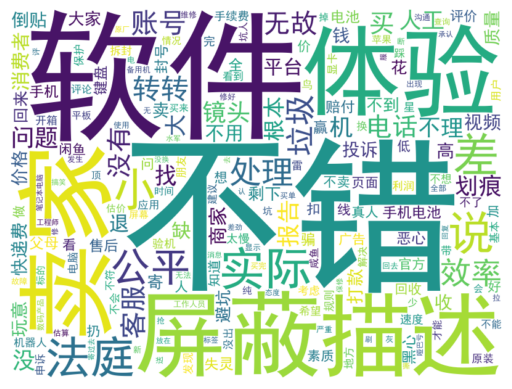

In [20]:
# 5. 生成词云
wordcloud = WordCloud(font_path="simhei.ttf", stopwords=STOPWORDS, background_color="white", max_words=200, width=800, height=600).generate(text) # 使用STOPWORDS避免常用字,max_words控制词云中词的最大数量
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 情感分析

In [21]:
# 4. 情感分析
def preprocess_text(text):
    """预处理文本：去除标点、数字、空白字符，并检查是否为空"""
    text = re.sub(r'[^\w\s]', '', text)  # 去除标点
    text = re.sub(r'\d+', '', text)      # 去除数字
    text = text.strip()                 # 去除首尾空白
    return text

def calculate_sentiment(text):
    """计算情感得分，处理 ZeroDivisionError 和其他异常"""
    text = preprocess_text(text)
    if not text:  # 检查处理后的文本是否为空
        return None  # 或者返回一个默认值，如 0.5 (中性)
    try:
        return SnowNLP(text).sentiments
    except ZeroDivisionError:
        return 0.5  # 或者返回一个默认值
    except Exception as e:
        print(f"An unexpected error occurred: {e}") # 记录其他异常信息
        return None #或者返回一个默认值

# 假设 df 已经加载了数据，并且有 '内容' 列
# 1. 清理空值（如果存在）
df = df.dropna(subset=['内容'])

# 2. 应用情感分析，处理异常
df["情感得分"] = df["内容"].apply(calculate_sentiment)
df

,评分,标题,内容,评级,分词内容,情感得分
0,5,让我比较了一宿,不错的软件,好评,不错 软件,0.812842
1,1,差,体验真差这些卖家动不动就屏蔽东西描述与实际差那么多还不给说了,差评,体验 真差 卖家 屏蔽 描述 实际 差 说,0.001726
2,5,公平审核,小法庭公平点,好评,小 法庭 公平,0.113775
3,1,差评,处理效率很差,差评,处理 效率 差,0.252380
4,1,垃圾转转不要用 账号无故被封 客服电话也没有,垃圾转转不要用 账号无故被封 客服电话也没有,差评,垃圾 转转 账号 无故 客服 电话 没有,0.000285
...,...,...,...,...,...,...
11624,5,闲鱼好评,非常好的app帮助大家出售购买闲置物品非常方便,好评,好 帮助 大家 购买 闲置 物品 方便,0.115048
11625,5,非常棒,门槛低 客流量大真的非常棒的APP,好评,门槛 低 客流量 大 棒,0.898567
11626,5,不错,很不错,好评,不错,0.920076
11627,1,坑,越来越坑哦 在平台卖了这么多次 以前也没有平台服务费 现在都玩上平台服务费了 卖了个的手机 扣我,差评,坑 平台 卖 没有 平台 服务费 玩 平台 服务费 卖 手机 扣,0.001701


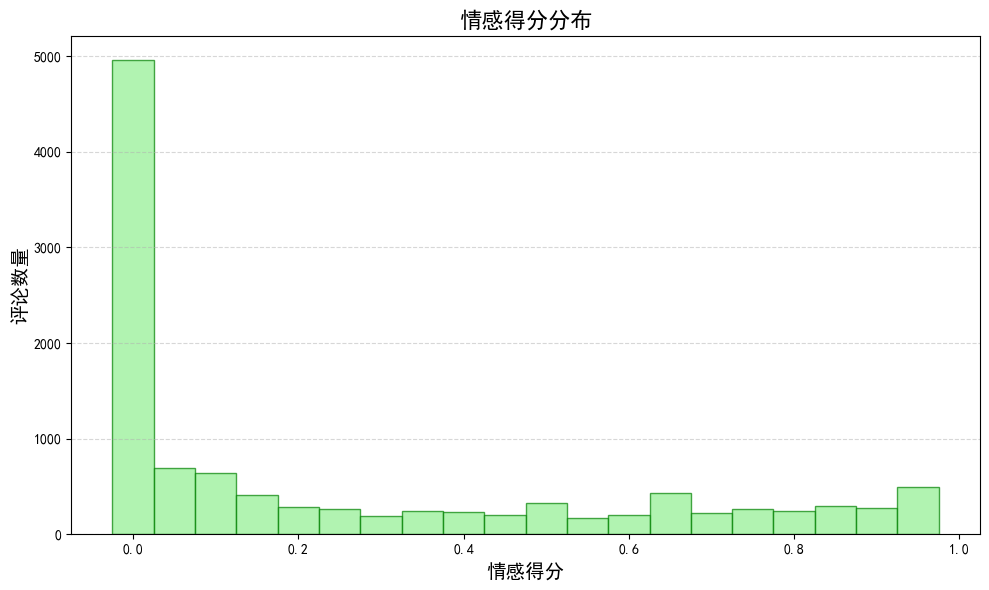

In [22]:
# --- 绘图部分 ---

# 1. 数据准备：计算情感得分的分布
# 使用 numpy 的 histogram 函数来计算各个区间的数量。
# bins=10 表示将情感得分范围 (0-1) 分成 20 个区间
hist, bins = np.histogram(df['情感得分'].dropna(), bins=20, range=(0, 1))

# 2. 设置绘图参数
plt.figure(figsize=(10, 6))  # 设置图形大小 (宽度, 高度)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为中文黑体 (或其他支持中文的字体)
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 3. 绘制柱状图
# 使用 plt.bar 绘制柱状图
# bins[:-1]：柱状图的 x 坐标，取 bins 数组的前 n-1 个元素（因为有 n 个区间，就有 n+1 个边界值）
# hist：柱状图的 y 坐标，即每个区间内的数量
# width：柱状图的宽度，这里设置为区间宽度 (bins[1] - bins[0])
# color：柱状图的颜色，设置为绿色 ('green')
# alpha：柱状图的透明度，设置为 0.7 (稍微透明)
# edgecolor: 柱状图边框的颜色, 设置为深绿色
plt.bar(bins[:-1], hist, width=(bins[1] - bins[0]), color='lightgreen', alpha=0.7, edgecolor='green')

# 4. 添加标签和标题
plt.xlabel('情感得分', fontsize=14)  # x 轴标签
plt.ylabel('评论数量', fontsize=14)  # y 轴标签
plt.title('情感得分分布', fontsize=16)  # 图表标题

# 5. 设置 x 轴刻度
# plt.xticks(bins, fontsize=12)  # 设置 x 轴刻度值和字体大小
# plt.yticks(fontsize=12)


# 6. 添加网格线 (可选)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # 添加 y 轴方向的虚线网格

# 7. 调整边距 (可选)
plt.tight_layout()

# 8. 保存高分辨率图像
plt.savefig('sentiment_distribution.png', dpi=300, bbox_inches='tight')  # 保存高分辨率图像

# 9. 显示图像
plt.show()

In [23]:
# 5. LDA 主题模型
texts = [jieba.lcut(comment) for comment in df["内容"]]
texts_str = [" ".join(text) for text in texts]
# 3. 使用 CountVectorizer 创建词袋模型
#    注意：这里不再需要 corpora.Dictionary
vectorizer = CountVectorizer(
    max_df=0.95,  # 忽略过于频繁的词 (可选)
    min_df=2,  # 忽略过于罕见的词 (可选)
    # max_features=1000,  # 限制词汇表大小 (可选)
)
X = vectorizer.fit_transform(texts_str)

主题数：2, 一致性分数：0.5381
主题数：3, 一致性分数：0.5310
主题数：4, 一致性分数：0.5157
主题数：5, 一致性分数：0.5215
主题数：6, 一致性分数：0.5123
主题数：7, 一致性分数：0.5010
主题数：8, 一致性分数：0.4994
主题数：9, 一致性分数：0.5110
主题数：10, 一致性分数：0.4677
主题数：11, 一致性分数：0.4747
主题数：12, 一致性分数：0.4493
主题数：13, 一致性分数：0.4787
主题数：14, 一致性分数：0.4614
主题数：15, 一致性分数：0.4471
主题数：16, 一致性分数：0.4579
主题数：17, 一致性分数：0.4776
主题数：18, 一致性分数：0.4594
主题数：19, 一致性分数：0.4813
主题数：20, 一致性分数：0.4754


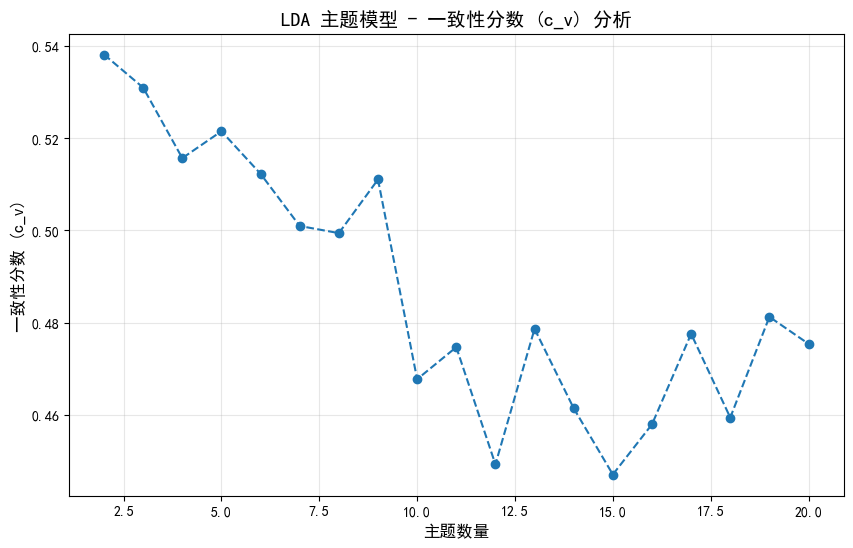

In [24]:
# TODO: 找个方法，确定主题数量，画个图
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

# 1. 构建词典和语料库
# texts 应是从评论分词后的列表，例如：texts = [["好", "软件"], ["卡顿", "差评"], ...]
dictionary = corpora.Dictionary(texts)  # 直接从分词后的 texts 创建词典
corpus = [dictionary.doc2bow(text) for text in texts]  # 转换为 Gensim 语料格式

# 2. 计算 c_v 一致性分数
coherences = []
topic_range = range(2, 21)  # 主题数量范围

for k in topic_range:
    # 训练 LDA 模型（增加 passes 参数确保收敛）
    lda_model = models.LdaModel(
        corpus=corpus,
        num_topics=k,
        id2word=dictionary,
        passes=10,          # 增加迭代次数
        random_state=42     # 固定随机种子
    )
    
    # 计算一致性分数
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    coherences.append(coherence_score)
    print(f"主题数：{k}, 一致性分数：{coherence_score:.4f}")

# 3. 可视化（优化中文显示）
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

plt.plot(topic_range, coherences, marker='o', linestyle='--')
plt.title("LDA 主题模型 - 一致性分数 (c_v) 分析", fontsize=14)
plt.xlabel("主题数量", fontsize=12)
plt.ylabel("一致性分数 (c_v)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
# 4. 创建并训练 LDA 模型
#    注意：这里不再需要 models.LdaModel
# FIXME: 主题数量需要根据困惑度确定。通常选择困惑度开始趋于平稳的那个点（“肘部法则”）。
lda = LatentDirichletAllocation(
    n_components=9,  # 主题数量
    random_state=0,  # 随机种子，保证结果可复现 (可选)
    learning_method='online', #推荐使用'online'，对于大数据集更快
)
lda.fit(X)

# 5. 打印主题
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10) # 打印每个主题的前 10 个词

# 6. (可选) 查看文档的主题分布
doc_topic_dist = lda.transform(X)
print(doc_topic_dist)  # 每行代表一个文档，每列代表一个主题的概率

Topic #0: 服务费 你们 什么 好评 怎么 不能 用户 知道 软件 申诉
Topic #1: 手机 转转 问题 平台 一个 客服 没有 这个 真的 倒闭
Topic #2: 恶心 假货 更新 没有 而且 差评 推荐 ios 一直 通过
Topic #3: 非常 手续费 不错 软件 不管 越来越 回收 价格 超级 满意
Topic #4: 已经 评论 删除 该条 闲鱼 注销 广告 全是 功能 曝光
Topic #5: 可以 支持 需要 不了 购买 完全 几个 起来 一次 注册
Topic #6: 平台 可以 闲置 一个 希望 方便 特别 东西 很多 二手
Topic #7: 闲鱼 直接 app 骗子 真的 物品 自己 东西 账号 好用
Topic #8: 平台 垃圾 卖家 买家 客服 没有 咸鱼 退款 软件 商家

[[0.03704382 0.03703708 0.03703704 ... 0.03703709 0.03703704 0.03704306]
 [0.01010454 0.10643785 0.01010117 ... 0.73072533 0.0101029  0.10222426]
 [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.37037023 0.03703704]
 ...
 [0.05555556 0.05555556 0.05555556 ... 0.05555556 0.05555556 0.05555556]
 [0.20319112 0.5592885  0.00854853 ... 0.00855868 0.10316955 0.00855587]
 [0.28968381 0.29030457 0.00264602 ... 0.04035129 0.1800216  0.05795526]]
